## Federated Learning using Boston dataset

In [55]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kernel import Kernel

from onlineKernels.klmsRFF import *
from onlineKernels.knlmsRFF import *
from onlineKernels.krlsRFF import *

from klms import *

from fl_sync import fl_sync
from fl_async import fl_async
from cent_learn import cent_learn
# Multiprocessing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

from sklearn.datasets import fetch_california_housing
from sklearn.utils import shuffle

Number of processors:  8


In [56]:
u,d = fetch_california_housing(return_X_y=True)
u,d = shuffle(u, d)

In [57]:
print(X[1])

[ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
  2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]


100%|█████████████████████████████████| 3/3 [00:09<00:00,  3.10s/it]


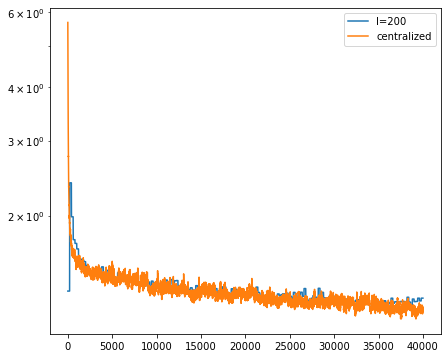

In [124]:
step_size = 0.8
reg_coeff = 0.1
threshold = 0.5
kernel = Kernel(1e-4)
# Federated learning: Synchronous updating rule
plt.figure(figsize=(7, 6))

K = 10 # K edge clients
c =  np.ones(K).reshape(K,1)/K # edge weighting
D = 200 # Dictionary size
L = [200]
iteration = 40000
num_experiments = 3

step_size = 0.9
KLMS_RFF = klms_rff(step_size,D)
# KLMS_RFF = KLMS(u,d,kernel,step_size,threshold,alpha_0=np.array(0).reshape(1,1))
KLMS_RFF_cent = klms_rff(0.2,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for l in L:
    amse = np.zeros(iteration)
    amse_cent = np.zeros(iteration)
    for epoch in tqdm(range(num_experiments)):

        # Process data and kernel
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(size=(8,D))
        b = np.random.uniform(0,2*np.pi,(D,1))
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
        
        mse_cent = cent_learn(iteration,K,KLMS_RFF_cent,h,u,d)
        amse_cent += mse_cent/num_experiments
        mse = fl_sync(iteration,K,KLMS_RFF,h,u,d,l)
        amse += mse/num_experiments

    plt.semilogy(range(len(amse)),amse,label="l=" + str(l))
plt.semilogy(range(len(amse_cent)),amse_cent,label="centralized")
plt.legend()
# plt.ylim([1e2,1e0])
# plt.xlim([0,3000])

In [125]:
amse

array([1.3315503 , 1.3315503 , 1.3315503 , ..., 1.28173854, 1.28173854,
       1.28173854])

In [126]:
amse_cent

array([5.67868643, 5.57062433, 5.51627921, ..., 1.21023909, 1.20876241,
       1.20983007])